In [105]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import cross_validate
import numpy as np
import pickle
import sqlite3

In [4]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

conn = create_connection('database/USRent.db')
sql_statement = """SELECT * FROM HousingList 
                   INNER JOIN Location ON HousingList.location_id = Location.location_id
                   INNER JOIN Parking ON HousingList.parking_id = Parking.parking_id
                   INNER JOIN Laundry ON HousingList.laundry_id = Laundry.laundry_id
                   INNER JOIN HousingType ON HousingList.housing_type_id = HousingType.housing_type_id;"""
data = pd.read_sql_query(sql_statement, conn)

In [159]:
df = data.copy(deep=True)

Remove columns that are not necessary for regression models

In [160]:
df.drop(["listing_id","location_id","region","housing_type_id","parking_id","laundry_id"], axis=1, inplace=True)

The price column is highly skewed on the right as seen in the eda analysis which would result in higher error values in regression. So we are limiting the prices between between 120 and 5000 USD and make sure the values are not zero.  

In [161]:
df=df[(df["price"] > 100) & (df["price"] < 5000)]
df=df[df["sqfeet"]>=120]

Since there are few categorical variables, we must encode them for the linear models. 

In [147]:
encoded_df = pd.get_dummies(df, drop_first=True)
encoded_df.head()

,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,...,housing_type_condo,housing_type_cottage/cabin,housing_type_duplex,housing_type_flat,housing_type_house,housing_type_in-law,housing_type_land,housing_type_loft,housing_type_manufactured,housing_type_townhouse
0,799,954,2,2.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1005,1117,2,2.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,750,763,2,2.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000,800,1,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,530,641,1,1.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split the target variable (price) and predictors for modeling

In [149]:
encoded_X = encoded_df.drop('price', axis=1)
encoded_y = encoded_df["price"]

After splitting the data, running some linear models with cross validation and with RMSE and R2 as metrics

In [150]:
linear = LinearRegression()
scores = cross_validate(linear, encoded_X, encoded_y, cv=5, scoring=['neg_mean_squared_error','r2'])
rmse = np.sqrt(np.absolute(np.mean(scores['test_neg_mean_squared_error'])))
r2 = np.mean(scores['test_r2'])
print(f"RMSE: {rmse:.2f} Adjusted_R2: {r2:.2f}")

RMSE: 407.19 Adjusted_R2: 0.43


In [151]:
linear.fit(encoded_X, encoded_y)
coef_table = pd.DataFrame(list(encoded_X.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",linear.coef_.transpose())
coef_table

,0,Coefs
0,sqfeet,0.000061
1,beds,-7.133584
2,baths,203.734884
3,cats_allowed,-28.889511
4,dogs_allowed,24.309912
...,...,...
77,housing_type_in-law,-111.208605
78,housing_type_land,-427.801153
79,housing_type_loft,125.240024
80,housing_type_manufactured,-152.538047


In [114]:
dtr = tree.DecisionTreeRegressor()
scores = cross_validate(dtr, encoded_X, encoded_y, cv=5, scoring=['neg_mean_squared_error','r2'])
rmse = np.sqrt(np.absolute(np.mean(scores['test_neg_mean_squared_error'])))
r2 = np.mean(scores['test_r2'])
print(f"RMSE: {rmse:.2f} Adjusted_R2: {r2:.2f}")

RMSE: 366.28 Adjusted_R2: 0.55


In [115]:
gbr = GradientBoostingRegressor()
scores = cross_validate(gbr, encoded_X, encoded_y, cv=5, scoring=['neg_mean_squared_error','r2'])
rmse = np.sqrt(np.absolute(np.mean(scores['test_neg_mean_squared_error'])))
r2 = np.mean(scores['test_r2'])
print(f"RMSE: {rmse:.2f} Adjusted_R2: {r2:.2f}")

RMSE: 389.18 Adjusted_R2: 0.48


After running three models, the decision tree regressor performed better than the other models in terms of "Root Mean Squared Error" and "Adjusted R2". This metric is choosen for evaluation as the target variable is continuous and goal of the project is to predict the price range of the house given its property.  

Plot a feature importance chart to find the factors that influence the rental price.

<AxesSubplot:title={'center':'Feature Importance'}>

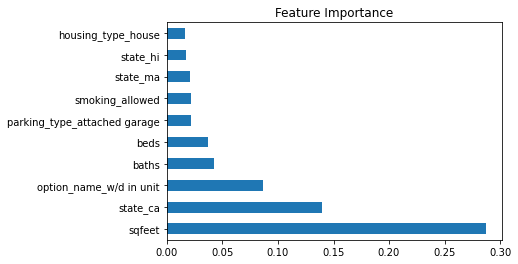

In [101]:
dtr.fit(encoded_X, encoded_y)
feature_importance = dtr.feature_importances_
feat_importances = pd.Series(dtr.feature_importances_, index=encoded_X.columns)
feat_importances.nlargest(10).plot(kind='barh', title="Feature Importance")

We could see certain features like sqfeet, number of beds, baths have significant influence in deciding the rental price of the house. We could also see some the names of the states like California, Masachussets and Hawaii which implies the rental price of houses are greatly affected by these places. 

Serilizaing and saving the model so it can be used for further inference later. 

In [ ]:
filename = 'prediction_model.sav'
pickle.dump(dtr, open(filename, 'wb'))